Problem Statement
With the vast amount of books available in the Google Books dataset, it can be challenging for publishers or platforms to predict the potential popularity of a book. By leveraging machine learning, we aim to predict the Average Rating of a book based on its metadata (e.g., title, authors, publisher, categories, etc.). This can help publishers better understand what factors contribute to a book's success and guide decisions in marketing or acquisitions.
Machine Learning Goal
To build a predictive model that estimates a book's Average Rating using its metadata features.

In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import fnmatch

# machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# from library.sb_utils import save_file


In [2]:
# write a function to look for downloaded data
# the function should look for data and load it into a dataframe

def load_data(directory, search_string):
    # dictionary to store matching file paths
    dataframes = {}
    counter = 1
    
    # walk through the directort and its subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            # check if the file name contains the search_string
            if fnmatch.fnmatch(file.lower(), f"*{search_string.lower()}*"):
                # load each file into a dataframe
                df = pd.read_csv(os.path.join(root, file))
                
                # dynamically name each dataframe
                dataframes[f'df_{counter}'] = df

                # increment counter
                counter += 1

    return dataframes

In [3]:
path = r'C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\google_books'
file_name = 'random_books'
dataframes_dict = load_data(path, file_name)

In [4]:
# Assuming dataframes_dict contains your DataFrames
dataframes = list(dataframes_dict.values())  # Extract all DataFrames from the dictionary

# Concatenate all DataFrames vertically
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.shape

(180995, 10)

In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180995 entries, 0 to 180994
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          180969 non-null  object 
 1   Authors        124322 non-null  object 
 2   Publisher      86013 non-null   object 
 3   PublishedDate  179505 non-null  object 
 4   ISBN           94380 non-null   float64
 5   PageCount      177863 non-null  float64
 6   Categories     125108 non-null  object 
 7   AverageRating  32889 non-null   float64
 8   RatingsCount   32889 non-null   float64
 9   Language       180995 non-null  object 
dtypes: float64(4), object(6)
memory usage: 13.8+ MB


Well! A lot of books were fetched, but some of these columns have a lot of missing data. 

These columns will be important to the model training. The missing data will have to be dropped.

Explore the data

In [6]:
combined_df.head()

,Title,Authors,Publisher,PublishedDate,ISBN,PageCount,Categories,AverageRating,RatingsCount,Language
0,The Berenstains' B Book,"Stan Berenstain, Jan Berenstain",Random House Books for Young Readers,1971,NaN,36.0,Juvenile Nonfiction,NaN,NaN,en
1,"B, Book, and Me",Sa-gwa Kim,NaN,2020,9.781932e+12,0.0,Young Adult Fiction,NaN,NaN,en
2,Option B,"Sheryl Sandberg, Adam Grant",Knopf,2017-04-24,9.781525e+12,241.0,Biography & Autobiography,NaN,NaN,en
3,My 'o' Sound Box,Jane Belk Moncure,Jane Belk Moncure Collection,2018-08,9.781504e+12,0.0,Alphabet,NaN,NaN,en
4,XOM-B,Jeremy Robinson,Macmillan,2014-04-29,9.781250e+12,353.0,Fiction,NaN,NaN,en


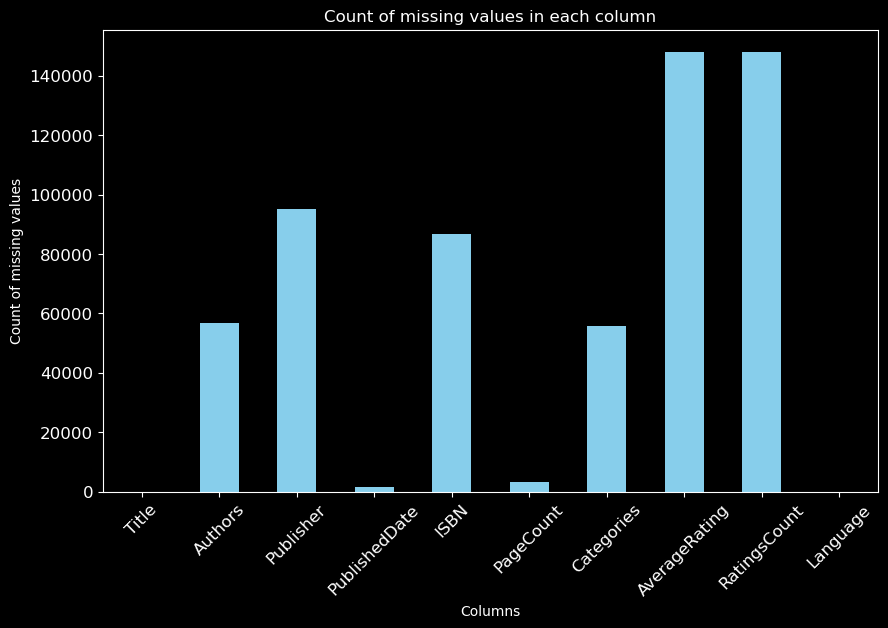

In [7]:
# check for missing values, simple histogram of counts of missing values in each column
combined_df.isna().sum().plot(kind='bar',
                              title='Count of missing values in each column',
                              xlabel='Columns',
                              ylabel='Count of missing values',
                              figsize=(10, 6),
                              color='skyblue',
                              rot=45,
                              fontsize=12)
plt.show()

In [8]:
# drop all missing values
combined_df.dropna(inplace=True)

In [9]:
# drop rows with 'PageCount' == 0
zero_pages = combined_df[combined_df['PageCount'] == 0]
combined_df.drop(zero_pages.index, inplace=True)

In [10]:
# check that all published dates are the same format, and have YYYY-MM-DD, I think some have only YYYY
combined_df['PublishedDate'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}').all()

False

In [11]:
# find all rows with only year in the 'PublishedDate' column
year_only = combined_df['PublishedDate'].str.match(r'^\d{4}$')
year_only.sum()

3134

In [12]:
# add '-01-01' to the end of the year only rows
combined_df.loc[year_only, 'PublishedDate'] = combined_df.loc[year_only, 'PublishedDate'] + '-01-01'

In [13]:
# convert the PublishedDate column to datetime
combined_df['PublishedDate'] = pd.to_datetime(combined_df['PublishedDate'], errors='coerce')

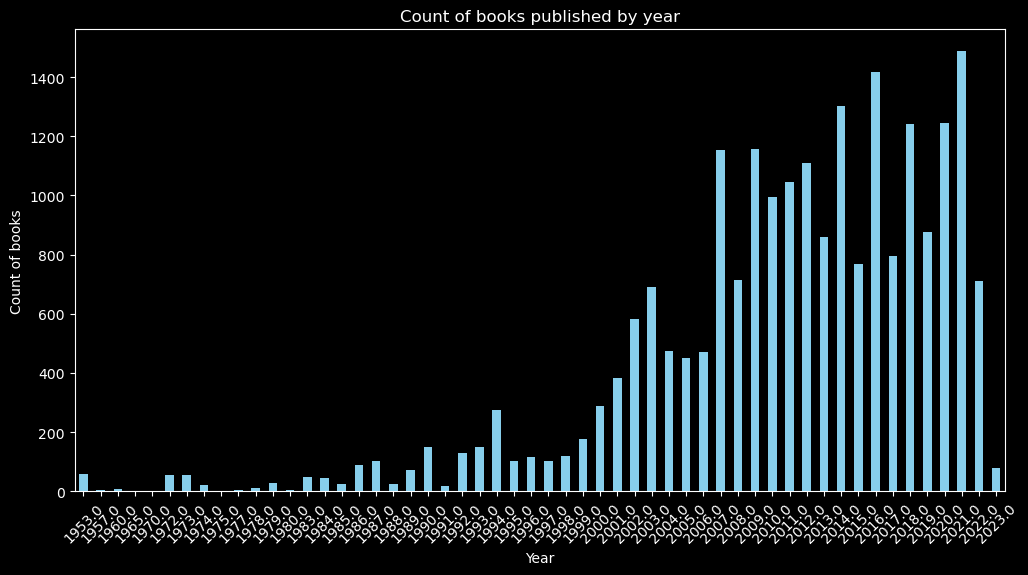

In [14]:
# check the distribution of books published by year
combined_df['PublishedDate'].dt.year.value_counts().sort_index().plot(kind='bar', figsize=(12, 6), color='skyblue', rot=45)
plt.title('Count of books published by year')
plt.xlabel('Year')
plt.ylabel('Count of books')
plt.show()

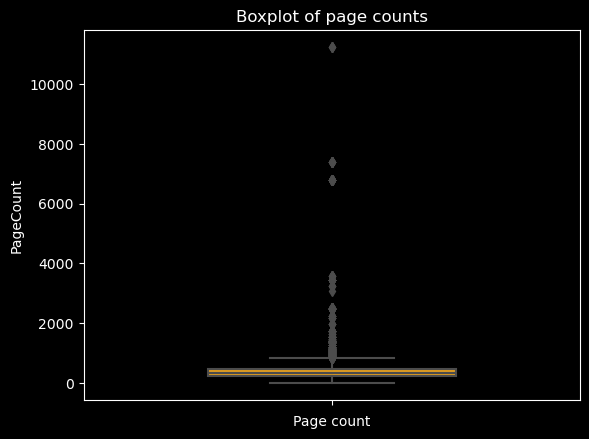

In [15]:
# boxplot of page counts
sns.boxplot(data=combined_df, y='PageCount', color='orange', width=0.5, linewidth=1.5, fliersize=5)
plt.title('Boxplot of page counts')
plt.xlabel('Page count')
plt.show()

c:\Users\adame\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


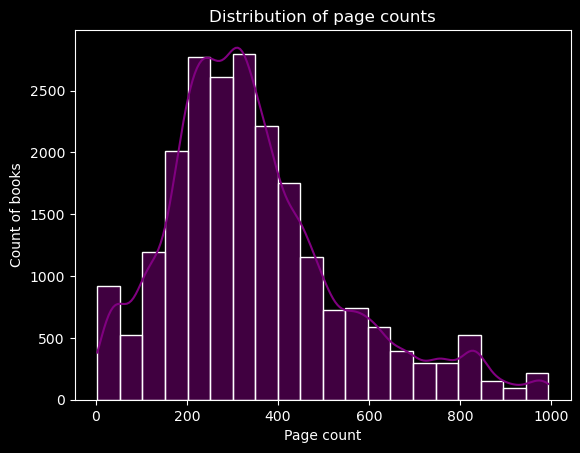

In [16]:
# this plot looks crazy, let's check the distribution of page counts with books that have less than 1000 pages
sns.histplot(data=combined_df[combined_df['PageCount'] < 1000], x='PageCount', bins=20, kde=True, color='purple')
plt.title('Distribution of page counts')
plt.xlabel('Page count')
plt.ylabel('Count of books')
plt.show()

In [17]:
# how many books have more than 1000 pages
combined_df[combined_df['PageCount'] > 1000].shape[0]

770

Thats a lot of books, I will keep them

c:\Users\adame\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


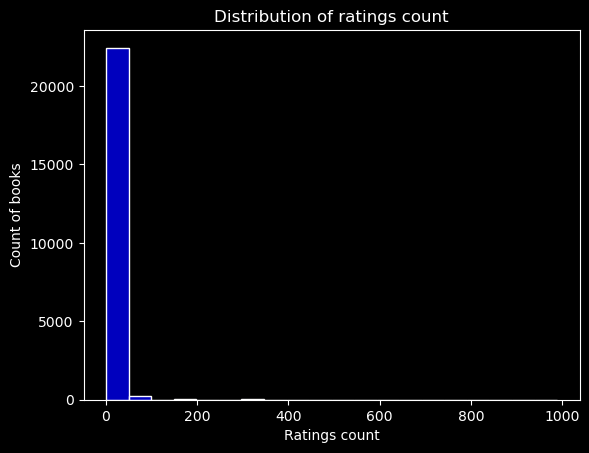

In [19]:
# check the distribution of ratings count
sns.histplot(data=combined_df, x='RatingsCount', bins=20, color='blue')
plt.title('Distribution of ratings count')
plt.xlabel('Ratings count')
plt.ylabel('Count of books')
plt.show()

c:\Users\adame\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


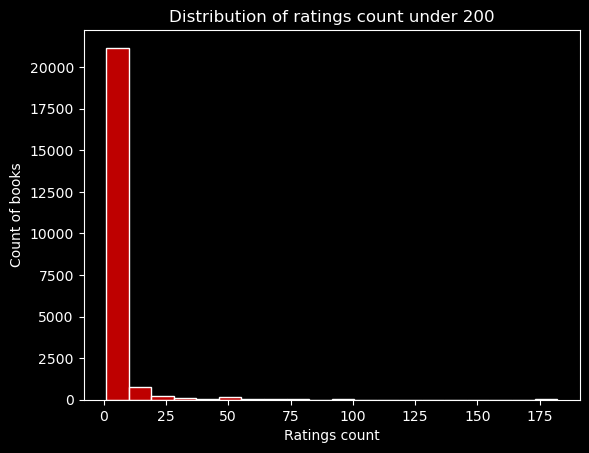

In [20]:
# plot ratings under 200
sns.histplot(data=combined_df[combined_df['RatingsCount'] < 200], x='RatingsCount', bins=20, color='red')
plt.title('Distribution of ratings count under 200')
plt.xlabel('Ratings count')
plt.ylabel('Count of books')
plt.show()

A lot of books have just one review

In [21]:
combined_df['RatingsCount'].value_counts()

RatingsCount
1.0      12134
2.0       4197
3.0       1970
4.0        904
5.0        796
         ...  
989.0        2
300.0        1
109.0        1
769.0        1
20.0         1
Name: count, Length: 61, dtype: int64

Inspect the Average_rating column

c:\Users\adame\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


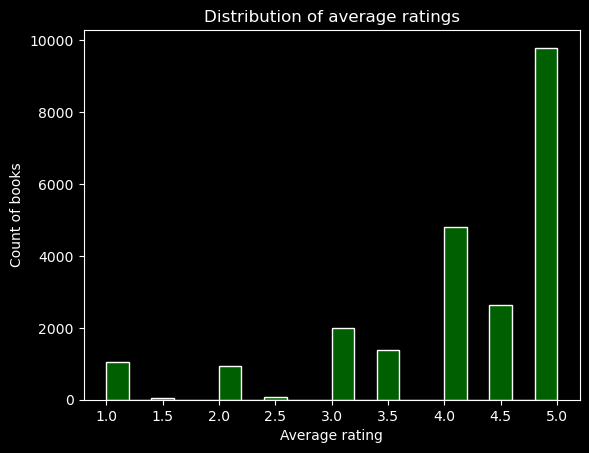

In [37]:
# plot the distribution of average ratings
sns.histplot(data=combined_df, 
             x='AverageRating', 
             bins=20, 
             color='green')
plt.title('Distribution of average ratings')
plt.xlabel('Average rating')
plt.ylabel('Count of books')
plt.show()

Pipeline for encoding and preprocessing

In [ ]:
# encode the 'Language' column
encoder = OneHotEncoder(sparse_output=False, drop='first')
language_encoded = encoder.fit_transform(combined_df[['Language']])
language_encoded_df = pd.DataFrame(language_encoded, columns=encoder.get_feature_names_out(['Language']))

# these two lines fix an issue with mis-aligned indexes
combined_df.reset_index(drop=True, inplace=True)
language_encoded_df.reset_index(drop=True, inplace=True)

combined_df = pd.concat([combined_df, language_encoded_df], axis=1)




combined_df.drop('Language', axis=1, inplace=True)

In [ ]:
# encode the publisher column
publisher_encoded = encoder.fit_transform(combined_df[['Publisher']])

publisher_encoded_df = pd.DataFrame(publisher_encoded, columns=encoder.get_feature_names_out(['Publisher']))

combined_df = pd.concat([combined_df, publisher_encoded_df], axis=1)

combined_df.drop('Publisher', axis=1, inplace=True)

In [29]:
# add a column for the number of words in the title
combined_df['TitleWordCount'] = combined_df['Title'].str.split().apply(len)

In [32]:
combined_df.head()

,Title,Authors,Publisher,PublishedDate,ISBN,PageCount,Categories,AverageRating,RatingsCount,Language,Language_en,Language_es,TitleWordCount
0,The Theory of H(b) Spaces: Volume 2,"Emmanuel Fricain, Javad Mashreghi",Cambridge University Press,2016-10-20,9.781316e+12,641.0,Mathematics,5.0,1.0,en,1.0,0.0,7
1,The Story of B,Daniel Quinn,Bantam,2010-01-13,9.780308e+12,350.0,Fiction,4.5,16.0,en,1.0,0.0,4
2,So B. It,Sarah Weeks,Zondervan,2009-10-20,9.780062e+12,276.0,Juvenile Fiction,2.0,3.0,en,1.0,0.0,3
3,"Ramble Book: Musings on Childhood, Friendship,...",Adam Buxton,HarperCollins UK,2020-09-03,9.780008e+12,348.0,Biography & Autobiography,5.0,1.0,en,1.0,0.0,11
4,Jumping the Scratch,Sarah Weeks,Harper Collins,2009-10-20,9.780062e+12,196.0,Juvenile Fiction,5.0,1.0,en,1.0,0.0,3


In [31]:
combined_df.to_csv('combined_books.csv', index=False)